# Application: Heterogeneous Effect of Gender on Wage Using Double Lasso

 We use US census data from the year 2012 to analyse the effect of gender and interaction effects of other variables with gender on wage jointly. The dependent variable is the logarithm of the wage, the target variable is *female* (in combination with other variables). All other variables denote some other socio-economic characteristics, e.g. marital status, education, and experience.  For a detailed description of the variables we refer to the help page.



This analysis allows a closer look how discrimination according to gender is related to other socio-economic variables.



In [88]:
import hdmpy
import pyreadr
import patsy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy import stats
import numpy as np
import scipy.linalg as sci_lag

In [2]:
cps2012_env = pyreadr.read_r("../data/cps2012.Rdata")
cps2012 = cps2012_env[ 'data' ]
cps2012.describe()

,year,lnw,female,widowed,divorced,separated,nevermarried,hsd08,hsd911,hsg,cg,ad,mw,so,we,exp1,exp2,exp3,exp4,weight
count,29217.0,29217.000000,29217.000000,29217.000000,29217.000000,29217.000000,29217.000000,29217.000000,29217.000000,29217.000000,29217.000000,29217.000000,29217.000000,29217.000000,29217.000000,29217.000000,29217.000000,29217.000000,29217.000000,29217.000000
mean,2012.0,2.797007,0.428757,0.007975,0.113393,0.016600,0.156347,0.004107,0.022179,0.247288,0.283431,0.155800,0.291645,0.282849,0.199644,18.756939,4.286811,10.875998,29.408779,1513.842566
std,0.0,0.662406,0.494907,0.088947,0.317078,0.127769,0.363191,0.063957,0.147267,0.431443,0.450671,0.362672,0.454528,0.450391,0.399740,8.767040,3.321506,11.121864,36.569919,1009.811610
min,2012.0,-7.469874,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,106.790000
25%,2012.0,2.408296,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.500000,1.322500,1.520875,1.749006,654.240000
50%,2012.0,2.774540,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000,3.610000,6.859000,13.032100,1472.100000
75%,2012.0,3.181569,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,26.000000,6.760000,17.576000,45.697600,1966.630000
max,2012.0,5.970942,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,43.500000,18.922500,82.312875,358.061006,6444.150000


In [3]:
formula_basic =  '''lnw ~ -1 + female + female:(widowed + divorced + separated + nevermarried +
hsd08 + hsd911 + hsg + cg + ad + mw + so + we + exp1 + exp2 + exp3) + +(widowed +
divorced + separated + nevermarried + hsd08 + hsd911 + hsg + cg + ad + mw + so +
we + exp1 + exp2 + exp3) ** 2'''

y, X = patsy.dmatrices(formula_basic, cps2012, return_type='dataframe')
X.shape[1]

136

We have the same number of covariables.

In [4]:
variance_cols = X.var().to_numpy()
X = X.iloc[ : ,  np.where( variance_cols != 0   )[0] ]

def demean(x):
    dif = x - np.mean( x )
    return dif 

X = X.apply( demean, axis = 0 )

index_gender = np.where( X.columns.str.contains('female'))[0]

The parameter estimates for the target parameters, i.e. all coefficients related to gender (i.e. by interaction with other variables) are calculated and summarized by the following commands:

In [5]:
effect_female = hdmpy.rlassoEffects( x = X , y = y , index = index_gender )

In [6]:
result_coeff = pd.concat( [ effect_female.res.get( 'coefficients' ).rename(columns = { 0 : "Estimate." }) , \
             effect_female.res.get( 'se' ).rename( columns = { 0 : "Std. Error" } ) , \
             effect_female.res.get( 't' ).rename( columns = { 0 : "t value" } ) , \
             effect_female.res.get( 'pval' ).rename( columns = { 0 : "Pr(>|t|)" } ) ] ,\
             axis = 1 )

print( result_coeff )

result_coeff.round( 3 ).to_latex()

                     Estimate.  Std. Error   t value      Pr(>|t|)
female               -0.154593    0.048599 -3.180992  1.467717e-03
female:widowed        0.136096    0.094115  1.446056  1.481614e-01
female:divorced       0.136939    0.021680  6.316402  2.677227e-10
female:separated      0.023303    0.048849  0.477034  6.333381e-01
female:nevermarried   0.186853    0.020094  9.299104  1.416347e-20
female:hsd08          0.027810    0.140357  0.198140  8.429356e-01
female:hsd911        -0.119335    0.052223 -2.285101  2.230692e-02
female:hsg           -0.012885    0.018229 -0.706850  4.796595e-01
female:cg             0.010139    0.018079  0.560797  5.749360e-01
female:ad            -0.030464    0.022807 -1.335714  1.816429e-01
female:mw            -0.001063    0.018715 -0.056822  9.546869e-01
female:so            -0.008183    0.019027 -0.430096  6.671256e-01
female:we            -0.004226    0.021422 -0.197281  8.436076e-01
female:exp1           0.004733    0.007483  0.632488  5.270682

'\\begin{tabular}{lrrrr}\n\\toprule\n{} &  Estimate. &  Std. Error &  t value &  Pr(>|t|) \\\\\n\\midrule\nfemale              &     -0.155 &       0.049 &   -3.181 &     0.001 \\\\\nfemale:widowed      &      0.136 &       0.094 &    1.446 &     0.148 \\\\\nfemale:divorced     &      0.137 &       0.022 &    6.316 &     0.000 \\\\\nfemale:separated    &      0.023 &       0.049 &    0.477 &     0.633 \\\\\nfemale:nevermarried &      0.187 &       0.020 &    9.299 &     0.000 \\\\\nfemale:hsd08        &      0.028 &       0.140 &    0.198 &     0.843 \\\\\nfemale:hsd911       &     -0.119 &       0.052 &   -2.285 &     0.022 \\\\\nfemale:hsg          &     -0.013 &       0.018 &   -0.707 &     0.480 \\\\\nfemale:cg           &      0.010 &       0.018 &    0.561 &     0.575 \\\\\nfemale:ad           &     -0.030 &       0.023 &   -1.336 &     0.182 \\\\\nfemale:mw           &     -0.001 &       0.019 &   -0.057 &     0.955 \\\\\nfemale:so           &     -0.008 &       0.019 &   -0.430

Now, we estimate and plot confident intervals, first "pointwise" and then the joint confidence intervals.

In [56]:
e = effect_female.res['residuals']['e']

In [57]:
v = effect_female.res['residuals']['v']

In [60]:
v.shape

(29217, 16)

In [59]:
e.shape

(29217, 16)

In [67]:
ev = e.to_numpy() * v.to_numpy()

In [74]:
Ev2 = (v ** 2).mean( axis = 0 ).to_numpy()

In [63]:
k = e.shape[1]

In [64]:
Omegahat = np.zeros( ( k , k ) )

In [81]:
for j in range( 0 , k ):
    for l in range( 0 , k ):
        Omegahat[ j , l ] = 1 / ( Ev2[ j ] * Ev2[ l ] ) * np.mean(ev[ : , j ] * ev[ : , l ] )
        Omegahat[ l , j ] = 1 / ( Ev2[ j ] * Ev2[ l ] ) * np.mean(ev[ : , j ] * ev[ : , l ] )

In [83]:
var = np.diagonal( Omegahat )

In [97]:
mu = np.repeat( 0, k )

In [98]:
p = len( mu )

In [100]:
n = 1

In [92]:
ev = sci_lag.eig( Omegahat )[ 0 ]
vectors = sci_lag.eig( Omegahat )[ 1 ]

In [95]:
np.array([2, 4, 5, 6]).reshape(2, 2).transpose()

array([[2, 5],
       [4, 6]])

In [104]:
X = np.random.normal(0, 1 ,  p * n ).reshape( n , p )

In [105]:
np.maximum( ev, 0 )

array([5.76134532e+02+0.j, 2.58967927e+02+0.j, 9.75691108e+01+0.j,
       8.05846490e+01+0.j, 6.94907403e+01+0.j, 3.68431286e+01+0.j,
       2.22183627e+01+0.j, 1.57345931e+01+0.j, 1.36349078e+01+0.j,
       1.63858142e-01+0.j, 3.82133543e-01+0.j, 9.94024373e+00+0.j,
       8.19261656e+00+0.j, 5.04793885e+00+0.j, 4.44900679e+00+0.j,
       6.39829630e+00+0.j])

In [84]:
B = 500
sim = np.zeros( B )

In [ ]:
for i in range( 0 , B ):
    beta_i = 

In [87]:
function (n = 1, mu, Sigma, tol = 1e-06, empirical = FALSE, EISPACK = FALSE) 
{
    p <- length(mu)
    if (!all(dim(Sigma) == c(p, p))) 
        stop("incompatible arguments")
    if (EISPACK) 
        stop("'EISPACK' is no longer supported by R", domain = NA)
    eS <- eigen(Sigma, symmetric = TRUE)
    ev <- eS$values
    if (!all(ev >= -tol * abs(ev[1L]))) 
        stop("'Sigma' is not positive definite")
    X <- matrix(rnorm(p * n), n)
    if (empirical) {
        X <- scale(X, TRUE, FALSE)
        X <- X %*% svd(X, nu = 0)$v
        X <- scale(X, FALSE, TRUE)
    }
    X <- drop(mu) + eS$vectors %*% diag(sqrt(pmax(ev, 0)), p) %*% 
        t(X)
    nm <- names(mu)
    if (is.null(nm) && !is.null(dn <- dimnames(Sigma))) 
        nm <- dn[[1L]]
    dimnames(X) <- list(nm, NULL)
    if (n == 1) 
        drop(X)
    else t(X)
}

ModuleNotFoundError: No module named 'rpy2'

In [76]:
1/(Ev2[1] * Ev2[2]) * np.mean( ev[ : , 1] * ev[ : , 2] )

0.4258932596538947

In [80]:
np.array( [2, 3, 5, 6 ] ) * np.array( [3, 4, 5, 6 ] )

array([ 6, 12, 25, 36])

In [ ]:
pointwise_CI

In [47]:
t_value = stats.t.ppf(1-0.05, 29217 - 116 -1 )

In [48]:
pointwise_CI = pd.DataFrame({ '5%' : result_coeff.iloc[ : , 0 ] \
                                     - result_coeff.iloc[ : , 1 ] * t_value ,\
                              '95%' : result_coeff.iloc[ : , 0 ] \
                             + result_coeff.iloc[ : , 1 ] * t_value })

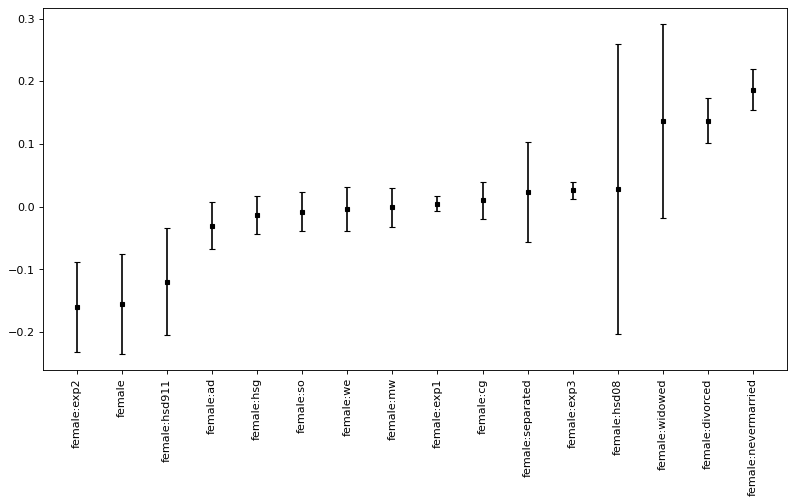

In [49]:
result_coeff = result_coeff.sort_values('Estimate.')

x = result_coeff.index

coef = result_coeff.iloc[ : , 0 ].to_numpy()

sd_error = ( result_coeff.iloc[ : , 1 ] * t_value ).to_numpy()

figure(figsize=(12, 6), dpi=80)

plt.errorbar( x = x , y = coef , yerr = sd_error , linestyle="None" , color = "black", \
              capsize = 3 , marker = "s" , markersize = 3 , mfc = "black" , mec = "black" )
plt.xticks(x, x, rotation=90)
plt.show()

Finally, we compare the pointwise confidence intervals to joint confidence intervals.

In [35]:
from statsmodels.sandbox.stats.multicomp import multipletests
import scipy.stats as st

In [30]:
# Getting pvalues from statistics
pval = result_coeff.iloc[:, 3].to_list()

In [29]:
# getting z scores from pvalues
p_adjusted = multipletests( pval , alpha = 0.9, method = 'bonferroni')

In [39]:
# getting z values
st.norm.ppf( .90 )

1.2815515655446004

In [31]:
joint_CI = pd.DataFrame({ '5%' : result_coeff.iloc[ : , 0 ] \
                                     - p_adjusted[1] * result_coeff.iloc[ : , 1 ] ,\
                              '95%' : result_coeff.iloc[ : , 0 ] \
                             + p_adjusted[1] * result_coeff.iloc[ : , 1 ] })

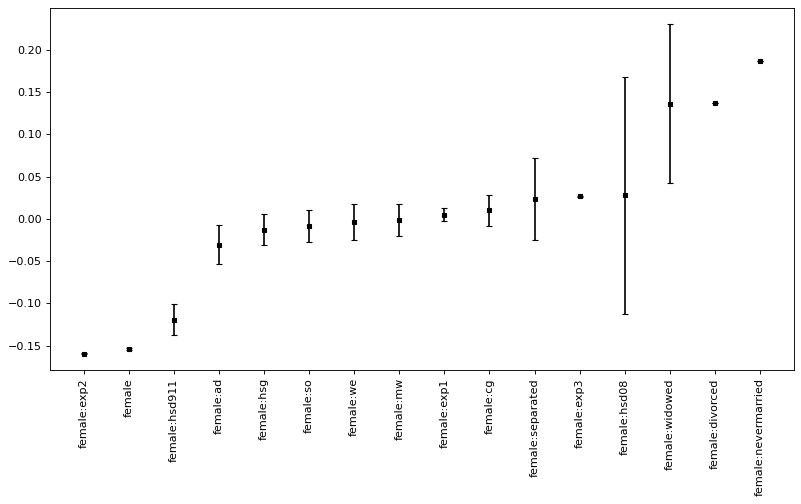

In [34]:
sd_error = ( p_adjusted[1] * result_coeff.iloc[ : , 1 ] ).to_numpy()

figure(figsize=(12, 6), dpi=80)

plt.errorbar( x = x , y = coef , yerr = sd_error , linestyle="None" , color = "black", \
              capsize = 3 , marker = "s" , markersize = 3 , mfc = "black" , mec = "black" )
plt.xticks(x, x, rotation=90)
plt.show()